In [2]:
import sklearn
import dataFrameTools
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from pathlib import Path
# import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
df=dataFrameTools.normalizeDF(0)
reduced=pd.read_csv(Path("../Data/BIKED_reduced.csv"), index_col=0)
reduced.BIKESTYLE=pd.Categorical(reduced.BIKESTYLE)
reduced['BIKESTYLECAT']=reduced.BIKESTYLE.cat.codes
classes=reduced["BIKESTYLECAT"]
print(reduced[["BIKESTYLECAT", "BIKESTYLE"]])
classes=sorted(reduced["BIKESTYLE"].unique())

#Drop classes with few models
cutoff=0
vcounts=reduced["BIKESTYLE"].value_counts()
print(vcounts)
classes=vcounts[vcounts>=cutoff].index
df = df[reduced['BIKESTYLE'].isin(list(classes))]

print(df)

target=reduced.loc[df.index].BIKESTYLE
inputvals=df


Loaded Imputed Dataframe in  0.8101954460144043 seconds
      BIKESTYLECAT  BIKESTYLE
1               14       ROAD
2                7  DIRT_JUMP
3               13       POLO
4               14       ROAD
5                7  DIRT_JUMP
...            ...        ...
4796             4   COMMUTER
4797            11        MTB
4798            14       ROAD
4799            14       ROAD
4800            14       ROAD

[4512 rows x 2 columns]
ROAD          1856
MTB            616
TRACK          470
OTHER          315
DIRT_JUMP      293
TOURING        201
CYCLOCROSS     151
POLO           128
TIMETRIAL       89
BMX             86
COMMUTER        75
CITY            72
CRUISER         42
HYBRID          39
TRIALS          35
GRAVEL          19
CARGO           14
CHILDRENS       10
FAT              1
Name: BIKESTYLE, dtype: int64
      SSSIDECX3  SSSIDECX2  SSSIDECX1  SSSIDECY2  SSSIDECY1  STEMBENDS  \
1      0.115968   0.213580   0.240722   0.173913   0.295455        0.0   
2      0.115968   0.

In [15]:
#Train model based on test set and evaluate performance on the test data, return score
def evaluatescore(numtests, data, method,train_size):
    st=time.time()
    scores=np.zeros(4)
    topscores=np.copy(scores)
    inputvals=data[0]
    targetvals=data[1]
    for i in range(numtests):
        score=np.copy(scores)
        X_train, X_test, y_train, y_test = train_test_split(inputvals, targetvals, train_size=train_size, shuffle=True)
#         X_train, X_test, y_train, y_test = customtts(inputvals, targetvals, train_size=train_size) #This line for custom train-test split
        if method=="svc":
            model = SVC(kernel="linear", C=0.025)
        if method=="nb":
            model=GaussianNB()
        if method=="Kn":
            model=KNeighborsClassifier(5)
        if method=="dt5":
            model=DecisionTreeClassifier(max_depth=5)
        if method=="dt8":
            model=DecisionTreeClassifier(max_depth=8)
        if method=="rf":
            model=RandomForestClassifier(max_depth=7, n_estimators=50)
        if method=="ada":
            model=AdaBoostClassifier()
        if method=="gpc":
            model=GaussianProcessClassifier(1.0 * RBF(1.0))
#         if method=="qda":
#             model=QuadraticDiscriminantAnalysis()
        if method=="mlp3":
            model=MLPClassifier(hidden_layer_sizes=(200), max_iter=5000)
        if method=="mlp4":
            model=MLPClassifier(hidden_layer_sizes=(200, 200), max_iter=5000)
        if method=="mlp5":
            model=MLPClassifier(hidden_layer_sizes=(200, 200, 200), max_iter=5000)
        if method=="mlp6":
            model=MLPClassifier(hidden_layer_sizes=(200, 200, 200), max_iter=5000)
        model.fit(X_train, y_train)
        score[0]=accuracy_score(y_test,model.predict(X_test))
        score[1]=recall_score(y_test,model.predict(X_test), average='macro', zero_division=0)
        score[2]=precision_score(y_test,model.predict(X_test), average='macro', zero_division=0)
        score[3]=f1_score(y_test,model.predict(X_test), average='macro')
        for i in range(len(score)):
            if score[i]>topscores[i]:
                topscores[i]=score[i]
        scores=[scores[i]+score[i]/numtests for i in range(len(score))]
    print(method+" evaluation time for " +str(train_size) + " train points: " + str((time.time() - st)))
    return scores, topscores
#Test all methods to generate method comparison dataframe
def testmethods(data,train_size):
    numtests=10
    models=["svc","nb","Kn","dt5","dt8","rf","ada","gpc","mlp3","mlp4","mlp5","mlp6"]
#     models=["dt5","dt8"]
    columns=['accuracy','recall','precision','f1']
    indices=[str(train_size)+model for model in models]
    for model in models:
        score, topscore=evaluatescore(numtests,data,model,train_size)
        if 'scorearr' in locals():
            scorearr=np.vstack([scorearr, score])
            topscorearr=np.vstack([topscorearr, topscore])
        else:
            scorearr=score
            topscorearr=topscore
    
    scoredf=pd.DataFrame(scorearr, index=indices, columns=columns)
    topscoredf=pd.DataFrame(topscorearr, index=indices, columns=columns)
#     arow=arow.join(pd.DataFrame({"Support Vector Classification": evaluatescore(numtests,data,"svc",train_size)},index=indices))
#     arow=arow.join(pd.DataFrame({"Naive Bayes": evaluatescore(numtests,data,"nb",train_size)},index=indices))
#     arow=arow.join(pd.DataFrame({"Depth 5 Decision Tree": evaluatescore(numtests,data,"dt5",train_size)},index=indices))
#     arow=arow.join(pd.DataFrame({"Depth 8 Decision Tree": evaluatescore(numtests,data,"dt8",train_size)},index=indices))
#     arow=arow.join(pd.DataFrame({"Random Forest": evaluatescore(numtests,data,"rf",train_size)},index=indices))
#     arow=arow.join(pd.DataFrame({"AdaBoost": evaluatescore(numtests,data,"ada",train_size)},index=indices))
#     arow=arow.join(pd.DataFrame({"Gaussian Process Classifier": evaluatescore(numtests,data,"gpc",train_size)},index=indices))
#    arow=arow.join(pd.DataFrame({"Quadratic Discriminant Analysis": evaluatescore(numtests,data,"qda",train_size)},index=indices))
#     arow=arow.join(pd.DataFrame({"3-layer Neural Net": evaluatescore(numtests,data,"mlp1",train_size)},index=indices))
#     arow=arow.join(pd.DataFrame({"4-layer Neural Net": evaluatescore(numtests,data,"mlp2",train_size)},index=indices))
#     arow=arow.join(pd.DataFrame({"5-layer Neural Net": evaluatescore(numtests,data,"mlp3",train_size)},index=indices))
#     arow=arow.join(pd.DataFrame({"6-layer Neural Net": evaluatescore(numtests,data,"mlp4",train_size)},index=indices))

    return scoredf,topscoredf

In [16]:
#Evaluate scores for several test sizes for several methods

scores=pd.DataFrame()
topscores=pd.DataFrame()
testvals=[200,600,1200,2000,3000]
for i in testvals:
    scoredf,topscoredf=testmethods([inputvals,target],i)
    scores=pd.concat([scores,scoredf])
    topscores=pd.concat([topscores,topscoredf])
print(scores)
print(topscores)
# ax=scores.plot.line(ylim=(50,100))
# ax.set_xlabel("Number of Training Samples")
# ax.set_ylabel("Classification Accuracy (%)")
# ax.legend(bbox_to_anchor=(1.02,1.42),ncol=2, fancybox=True, shadow=False, frameon=False)

svc evaluation time for 200 train points: 93.32062077522278
nb evaluation time for 200 train points: 42.56202816963196
Kn evaluation time for 200 train points: 117.86588501930237
dt5 evaluation time for 200 train points: 2.320814847946167
dt8 evaluation time for 200 train points: 2.3751606941223145
rf evaluation time for 200 train points: 3.7809813022613525
ada evaluation time for 200 train points: 46.58361625671387
gpc evaluation time for 200 train points: 1227.7664806842804
mlp3 evaluation time for 200 train points: 41.90315556526184
mlp4 evaluation time for 200 train points: 26.690866947174072
mlp5 evaluation time for 200 train points: 24.477450609207153
mlp6 evaluation time for 200 train points: 23.25664496421814
svc evaluation time for 600 train points: 236.42702054977417
nb evaluation time for 600 train points: 43.08830761909485
Kn evaluation time for 600 train points: 342.69329738616943
dt5 evaluation time for 600 train points: 2.459380865097046
dt8 evaluation time for 600 train

In [17]:
scores.to_csv("classification scores.csv")
topscores.to_csv("top classification scores.csv")

In [82]:
X_train, X_test, y_train, y_test = train_test_split(inputvals, target, train_size=3000, shuffle=True)
model=MLPClassifier(hidden_layer_sizes=(200, 200, 200), max_iter=5000)
model.fit(X_train,y_train)


MLPClassifier(hidden_layer_sizes=(200, 200, 200), max_iter=5000)

<AxesSubplot:>

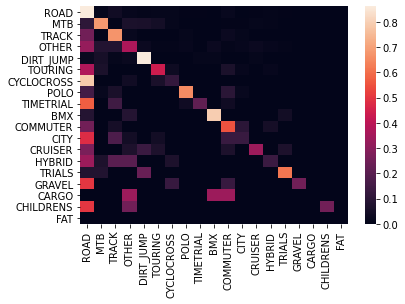

In [83]:
mat=sklearn.metrics.confusion_matrix(y_test, model.predict(X_test), labels=classes, sample_weight=None, normalize='true')
matdf=pd.DataFrame(mat, index=classes, columns=classes)
sns.heatmap(matdf)

In [34]:
shap.initjs()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(inputvals, target, train_size=3000, shuffle=True)
# model=DecisionTreeClassifier(max_depth=8)
model=RandomForestClassifier(max_depth=8, n_estimators=10)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(X_train)

0.6706349206349206


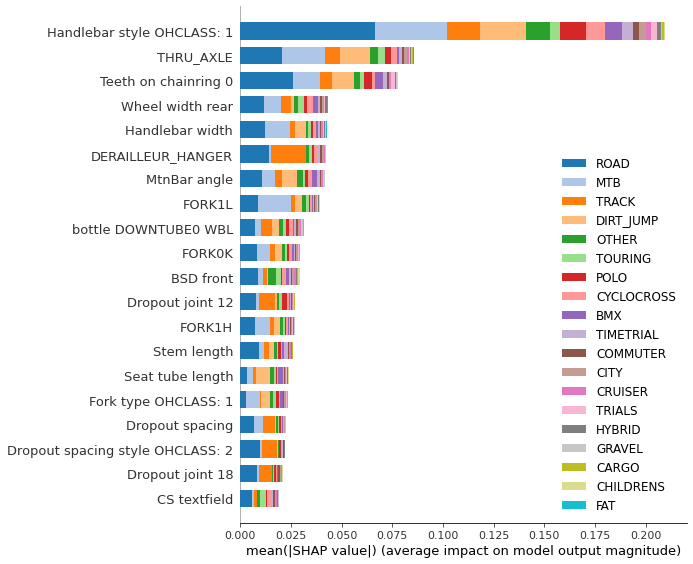

In [61]:
shap.summary_plot(shap_values, X_train,class_names=sorted(reduced["BIKESTYLE"].unique()),color=plt.get_cmap("tab20"))